In [1]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
import requests
from matplotlib import pyplot as plt
from matplotlib import style
import numpy as np


# Target website, S&P 500
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Add headers so Wikipedia thinks you are a browser
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'}

response = requests.get(url, headers=headers)
# raises an error if the request fails
response.raise_for_status()  

# Now parse the tables from the HTML text
tables = pd.read_html(response.text)


# Find which table contains the 'Symbol' and 'GICS Sector' columns
for i, table in enumerate(tables):
    print(f"Table {i} columns: {list(table.columns)}")

# The second table (index 1) is the S&P 500 list
dj = tables[0]
print(dj.head())

# Group tickers by industry and store in a dictionary
industry_dict = (
    dj
    .groupby('GICS Sector')['Symbol']
    .apply(list)
    .to_dict()
)

# Print nicely
for industry, tickers in industry_dict.items():
    print(f"{industry}: {tickers}")

C:\Users\leonc\AppData\Local\Temp\ipykernel_42216\162196217.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


Table 0 columns: ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded']
Table 1 columns: [('Effective Date', 'Effective Date'), ('Added', 'Ticker'), ('Added', 'Security'), ('Removed', 'Ticker'), ('Removed', 'Security'), ('Reason', 'Reason')]
  Symbol             Security             GICS Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois

In [11]:
def analysis(symbols, s_Date = "2024-09-01", e_Date = "2025-10-31"):
    all_data = []
    
    for ticker in symbols:
        # Download monthly data
        data = yf.download(ticker, start=s_Date, end=e_Date, interval="1d")
        data.columns = data.columns.get_level_values(0)
        
        # Keep only Open and Close
        data = data[['Open', 'Close']]
        data.reset_index(inplace=True)
        
        # Calculate percentage change
        data['% Change'] = ((data['Close'] - data['Open']) / data['Open']) * 100

        # Find 5DA and 20DA
        data['5DA'] = data['Close'].rolling(window=5).mean()
        data['20DA'] = data['Close'].rolling(window=20).mean()
        # Add ticker symbol
        data['Ticker'] = ticker
        data = data[['Date', 'Ticker', 'Open', 'Close', '% Change', '5DA', '20DA']]
        
        all_data.append(data)
    
    # Combine all data
    final = pd.concat(all_data, ignore_index=True)
    
    # # Format values
    # final['Open'] = final['Open'].apply(lambda x: f"${x:.2f}")
    # final['Close'] = final['Close'].apply(lambda x: f"${x:.2f}")
    # final['% Change'] = final['% Change'].apply(lambda x: f"{x:.2f}%")
    # final['5DA'] = final['5DA'].apply(lambda x: f"${x:.2f}" if pd.notnull(x) else "—")
    # final['20DA'] = final['20DA'].apply(lambda x: f"${x:.2f}" if pd.notnull(x) else "—")
    # # Sort by date and ticker
    # final = final.sort_values(by=['Date', 'Ticker'])
    
    # Display clean, centered table for each date
    # for date, group in final.groupby('Date'):
    #     print(f"\n{date.date()}")
    #     print(tabulate(group[['Ticker', 'Open', 'Close', '% Change']].values,
    #                    headers=['Ticker', 'Open', 'Close', '% Change'], 
    #                    tablefmt='pretty', 
    #                    stralign='center', 
    #                    numalign='center'))
    #     print()
    
    return final



C:\Users\leonc\AppData\Local\Temp\ipykernel_42216\3924897759.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1d")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_42216\3924897759.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1d")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_42216\3924897759.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1d")
[*********************100%***********************]  1 of 1 completed


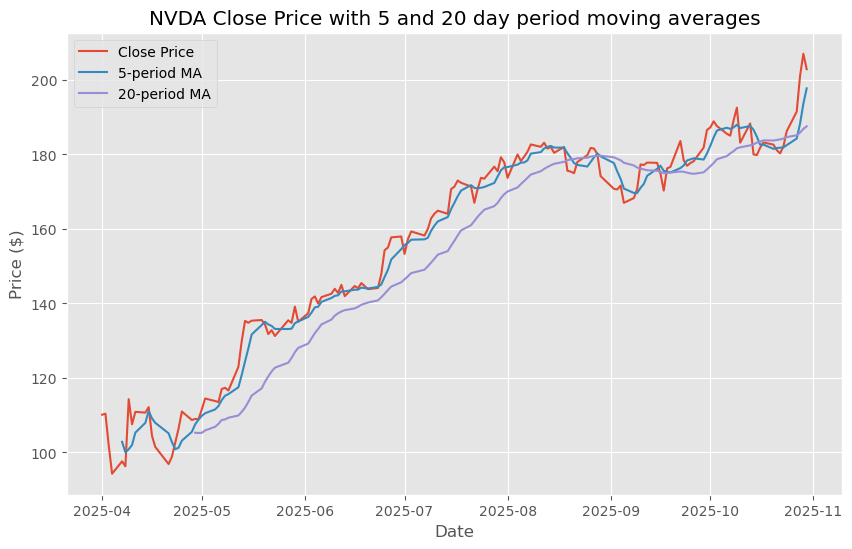

NVDA: BUY (5-day MA above 20-day MA and Close supports)


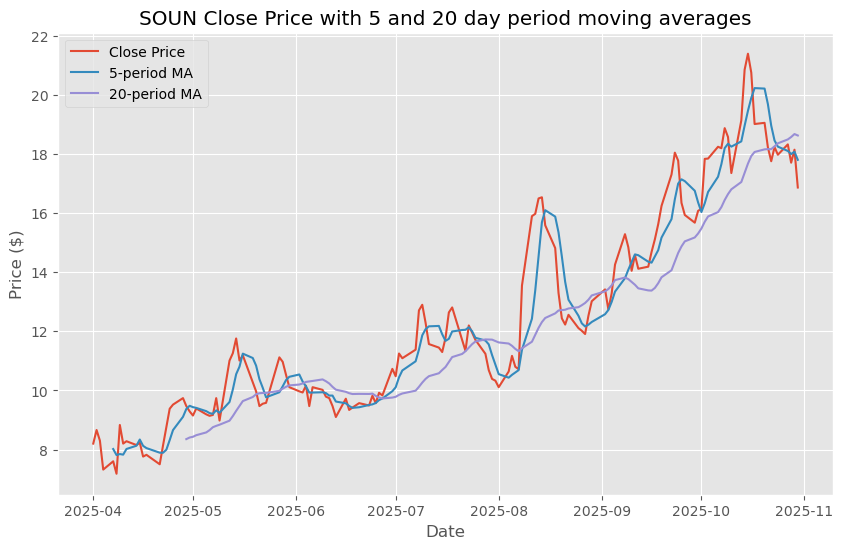

SOUN: SELL (5-day MA below 20-day MA)


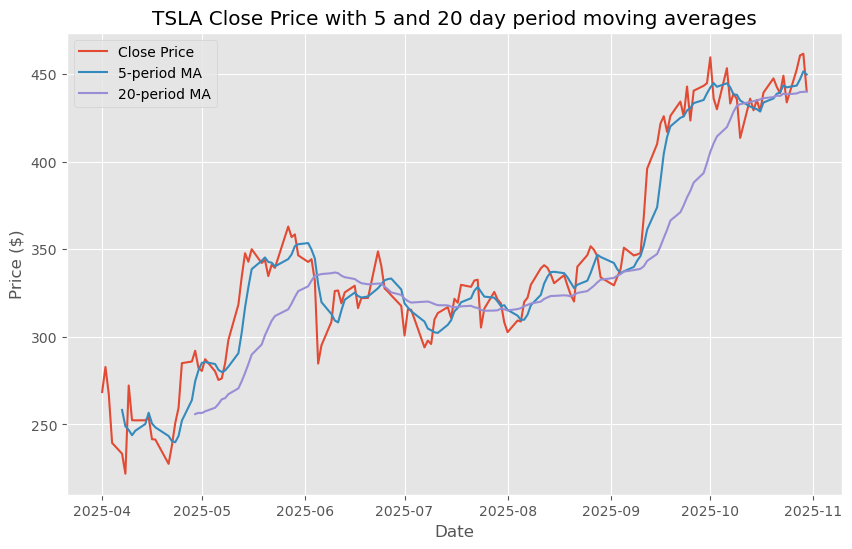

TSLA: Hold (5-day MA above 20-day MA, but Close does not support)


In [12]:
x = analysis(["TSLA", "NVDA", "SOUN"], "2025-04-01")
style.use("ggplot")

# Plot the closing price and moving averages on the same graph
for ticker, group in x.groupby("Ticker"):
    plt.figure(figsize=(10, 6))

    # Sort by date
    group = group.sort_values("Date")

    plt.plot(group["Date"], group["Close"], label="Close Price")
    plt.plot(group["Date"], group["5DA"], label="5-period MA")
    plt.plot(group["Date"], group["20DA"], label="20-period MA")
    
    # create title and labels 
    plt.title(f"{ticker} Close Price with 5 and 20 day period moving averages")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.show()

    # get rid of all blank values in the moving averages and compare last values in 5DA, 20DA, and closing price
    valid = group.dropna(subset=["5DA", "20DA"])
    if len(valid) > 0:
        last = valid.iloc[-1]
        if last["5DA"] > last["20DA"]:
            if last["Close"] > last["5DA"]:
                signal = "BUY (5-day MA above 20-day MA and Close supports)"
            else:
                signal = "Hold (5-day MA above 20-day MA, but Close does not support)"
        elif last["5DA"] < last["20DA"]:
            signal = "SELL (5-day MA below 20-day MA)"
        else:
            signal = "Hold ((5-day MA = 20-day MA)"
        print(f"{ticker}: {signal}")
    else:
        print(f"{ticker}: not enough data to compute moving averages.")


C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\4193377662.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1d")
[*********************100%***********************]  1 of 1 completed


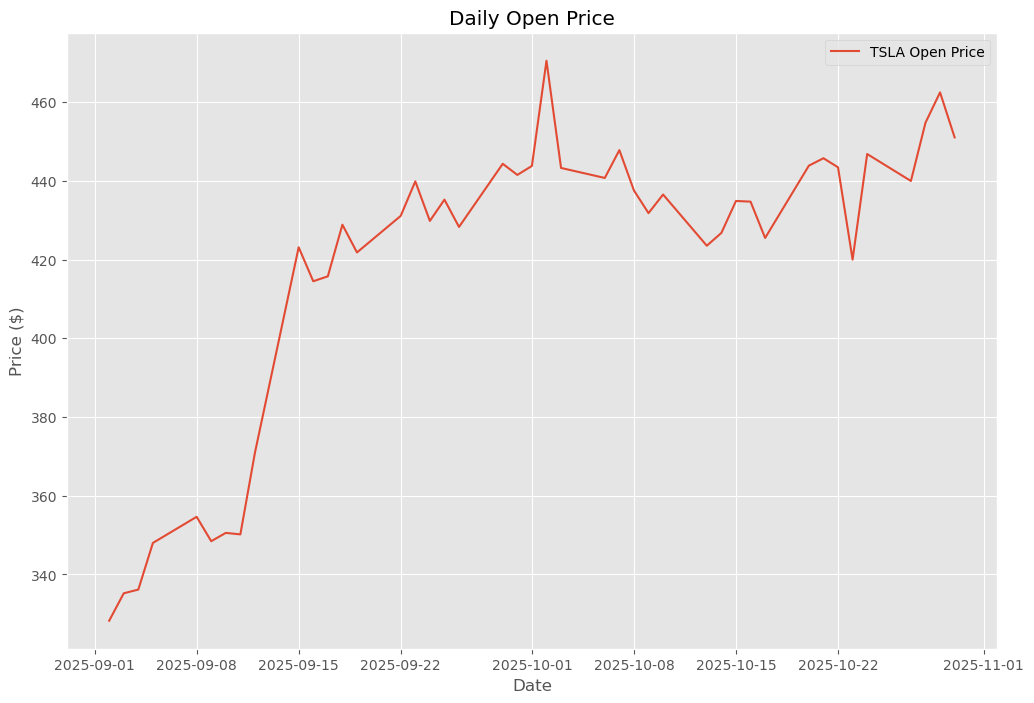

In [8]:
x = analysis(["TSLA"])

# Convert formatted strings back to numeric values
x["Open"] = x["Open"].replace('[\$,]', '', regex=True).astype(float)


# Plot
style.use("ggplot")
plt.figure(figsize=(12, 8))

for ticker, group in x.groupby("Ticker"):
    plt.plot(group["Date"], group["Open"], label=f"{ticker} Open Price")

plt.title("Daily Open Price")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

In [3]:
industry_results = {}
for industry, tickers in industry_dict.items():
    print(f"\n=== {industry} ===")
    final = analysis(tickers)
    industry_results[industry] = final


=== Communication Services ===


C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True



=== Consumer Discretionary ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWar


=== Consumer Staples ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1mo 2025-09-01 -> 2025-10-31)')
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*******************


=== Energy ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWar


=== Financials ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWar


=== Health Care ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWar


=== Industrials ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWar


=== Information Technology ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWar


=== Materials ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWar


=== Real Estate ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWar


=== Utilities ===


[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=s_Date, end=e_Date, interval="1mo")
[*********************100%***********************]  1 of 1 completed
C:\Users\leonc\AppData\Local\Temp\ipykernel_21928\3598108992.py:6: FutureWar

In [4]:
print(industry_results)

{'Communication Services': Price       Date Ticker     Open    Close % Change 5DA 20DA
6     2025-09-01   CHTR  $262.50  $275.11    4.80%   —    —
8     2025-09-01  CMCSA   $33.35   $31.09   -6.77%   —    —
44    2025-09-01    DIS  $117.02  $114.50   -2.15%   —    —
10    2025-09-01     EA  $170.00  $201.70   18.65%   —    —
14    2025-09-01    FOX   $53.74   $57.00    6.07%   —    —
12    2025-09-01   FOXA   $59.11   $62.77    6.20%   —    —
2     2025-09-01   GOOG  $208.80  $243.33   16.54%   —    —
0     2025-09-01  GOOGL  $208.25  $242.88   16.63%   —    —
16    2025-09-01    IPG   $26.03   $27.57    5.92%   —    —
18    2025-09-01    LYV  $164.30  $163.40   -0.55%   —    —
22    2025-09-01   META  $725.55  $733.88    1.15%   —    —
20    2025-09-01   MTCH   $36.52   $35.13   -3.81%   —    —
24    2025-09-01   NFLX  $119.70  $119.89    0.16%   —    —
28    2025-09-01    NWS   $33.43   $34.44    3.04%   —    —
26    2025-09-01   NWSA   $28.99   $30.61    5.57%   —    —
30    2025-09

In [9]:
print(x)

Price       Date Ticker    Open    Close % Change      5DA     20DA
0     2025-09-02   TSLA  328.23  $329.36    0.34%        —        —
1     2025-09-03   TSLA  335.20  $334.09   -0.33%        —        —
2     2025-09-04   TSLA  336.15  $338.53    0.71%        —        —
3     2025-09-05   TSLA  348.00  $350.84    0.82%        —        —
4     2025-09-08   TSLA  354.64  $346.40   -2.32%  $339.84        —
5     2025-09-09   TSLA  348.44  $346.97   -0.42%  $343.37        —
6     2025-09-10   TSLA  350.55  $347.79   -0.79%  $346.11        —
7     2025-09-11   TSLA  350.17  $368.81    5.32%  $352.16        —
8     2025-09-12   TSLA  370.94  $395.94    6.74%  $361.18        —
9     2025-09-15   TSLA  423.13  $410.04   -3.09%  $373.91        —
10    2025-09-16   TSLA  414.50  $421.62    1.72%  $388.84        —
11    2025-09-17   TSLA  415.75  $425.86    2.43%  $404.45        —
12    2025-09-18   TSLA  428.87  $416.85   -2.80%  $414.06        —
13    2025-09-19   TSLA  421.82  $426.07    1.01